##  AI MELANO CANCER DETECTION

## Step 1: Import Necessary Libraries

In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
import time

## Step 2: Loading image dataset

In [ ]:
# Path to the zip file
zip_file_path = r'C:\Users\Lenovo\Downloads\archive (1).zip'
extract_dir = r'C:\Users\Lenovo\Downloads\melanoma_images'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## Step 3: Count images

In [3]:
# Define the paths to your train and test directories after extraction
train_dir = os.path.join(extract_dir, 'melanoma_cancer_dataset', 'train')
test_dir = os.path.join(extract_dir, 'melanoma_cancer_dataset', 'test')

# Function to count images in each category (benign/malignant)
def count_images(directory):
    categories = ['benign', 'malignant']
    image_counts = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        image_counts[category] = len(os.listdir(category_path))
    return image_counts

# Count images in train and test sets
train_image_counts = count_images(train_dir)
test_image_counts = count_images(test_dir)

# Print the results
print("Train set image counts:", train_image_counts)

Train set image counts: {'benign': 5000, 'malignant': 4605}

## Step 4: Sample image size

In [3]:
import os
from PIL import Image

# Define the path to the benign directory
benign_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign'

# Number of sample images to display
num_samples = 5

# Loop through the first few images and display their dimensions
for i, image_file in enumerate(os.listdir(benign_path)[:num_samples]):
    image_path = os.path.join(benign_path, image_file)
    with Image.open(image_path) as img:
        print(f"Image {i+1}: {img.size}")  # Prints the dimensions of the image (width, height)

Image 1: (300, 300)Image 2: (300, 300)Image 3: (300, 300)Image 4: (300, 300)Image 5: (300, 300)

## Plot width and height distributions

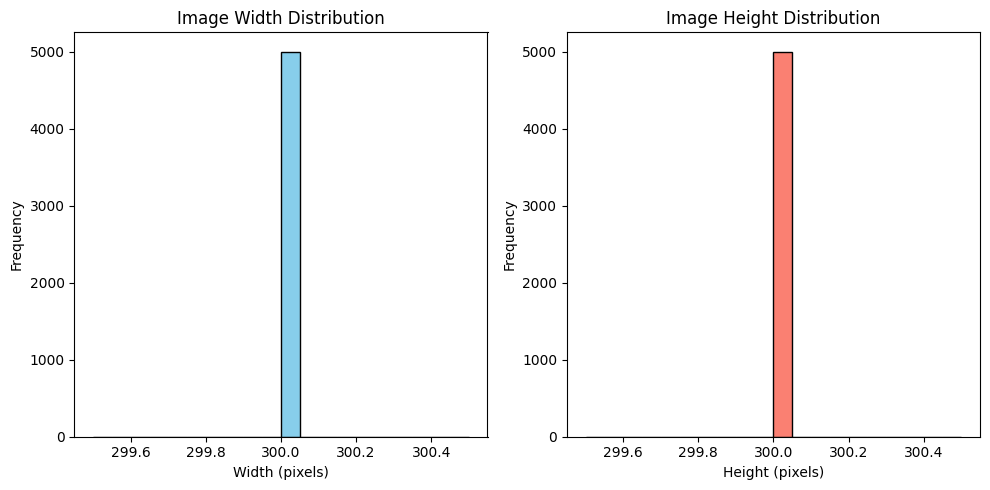

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the heading for this section
# Plot image size distribution in benign dataset

# Path to the benign images directory (adjust based on your structure)
benign_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign'

# Initialize a list to store image sizes
image_sizes = []

# Loop through images in the benign directory
for image_file in os.listdir(benign_path):
    image_path = os.path.join(benign_path, image_file)
    with Image.open(image_path) as img:
        # Append the size (width * height) to the list
        image_sizes.append(img.size)

# Separate width and height for plotting
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Plot width and height distributions
plt.figure(figsize=(10, 5))

# Plot width distribution
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Plot height distribution
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='salmon', edgecolor='black')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

##### Shows the frequency distribution of image widths (left) and heights (right), highlighting common image dimensions.

# Displaying Sample Images

Displaying benign images:

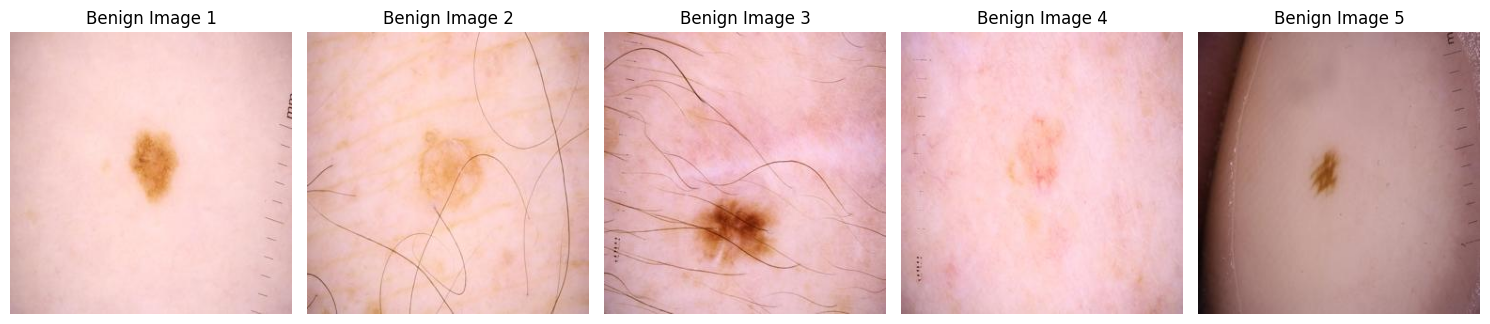

Displaying malignant images:

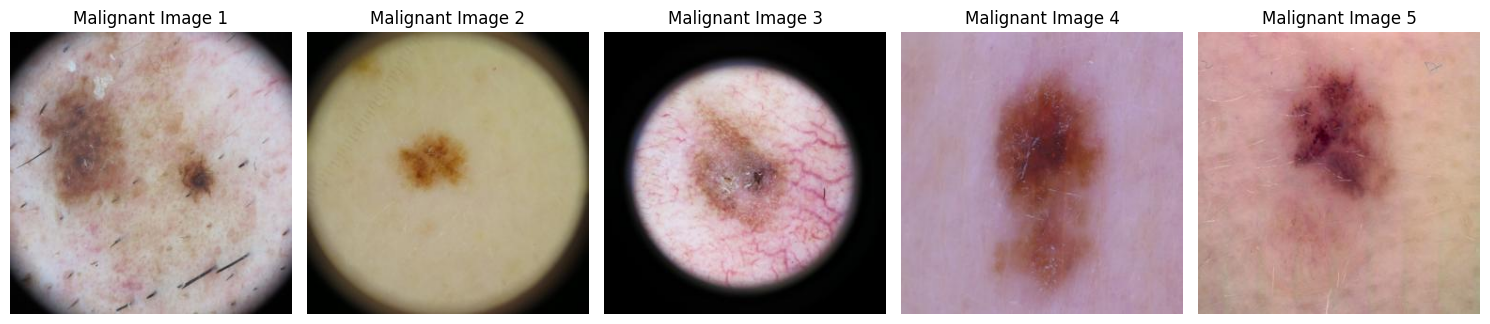

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the heading for this section
# Display 5 benign and 5 malignant images from melanoma dataset

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))  # Adjust the figure size for better layout
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} Image {i+1}")
    plt.tight_layout()
    plt.show()

# Get 5 images from each category (benign and malignant)
num_images = 5  # Number of images to display from each category
benign_images = [os.path.join(benign_path, img) for img in os.listdir(benign_path)[:num_images]]
malignant_images = [os.path.join(malignant_path, img) for img in os.listdir(malignant_path)[:num_images]]

# Display benign images
print("Displaying benign images:")
display_images(benign_images, "Benign")

# Display malignant images
print("Displaying malignant images:")
display_images(malignant_images, "Malignant")

## class distribution

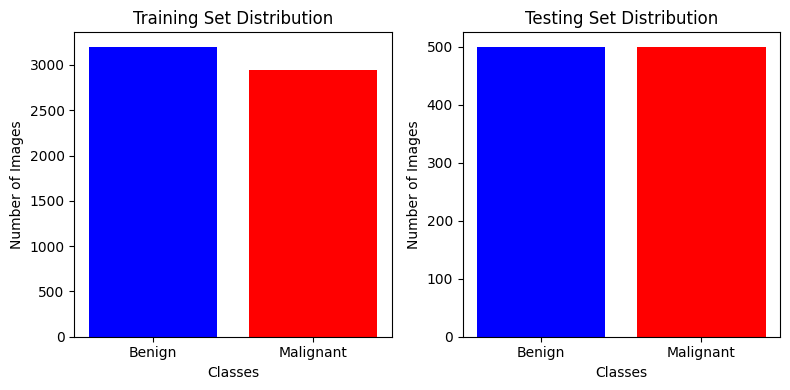

In [4]:
import os
import matplotlib.pyplot as plt

# Define the paths to the train and test directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
test_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\test'

# Function to count images in each class
def count_images(directory):
    benign_path = os.path.join(directory, 'benign')
    malignant_path = os.path.join(directory, 'malignant')

    benign_count = len(os.listdir(benign_path)) if os.path.exists(benign_path) else 0
    malignant_count = len(os.listdir(malignant_path)) if os.path.exists(malignant_path) else 0

    return benign_count, malignant_count

# Count images in train and test sets
train_benign_count, train_malignant_count = count_images(train_dir)
test_benign_count, test_malignant_count = count_images(test_dir)

# Plot class distribution for both sets
def plot_class_distribution(train_counts, test_counts):
    classes = ['Benign', 'Malignant']
    
    plt.figure(figsize=(8, 4))  # Reduced figure size

    # Plot for train set
    plt.subplot(1, 2, 1)
    plt.bar(classes, train_counts, color=['blue', 'red'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Training Set Distribution')

    # Plot for test set
    plt.subplot(1, 2, 2)
    plt.bar(classes, test_counts, color=['blue', 'red'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Testing Set Distribution')

    plt.tight_layout()
    plt.show()

# Execute the plot function
plot_class_distribution(
    [train_benign_count, train_malignant_count],
    [test_benign_count, test_malignant_count]
)

##### This code counts the number of benign and malignant images in both training and testing datasets, and then creates a side-by-side bar plot to visualize the class distribution for each dataset. It uses Matplotlib to display the number of images for each class, making it easier to compare the distributions.

## Pie Chart for class Distribution

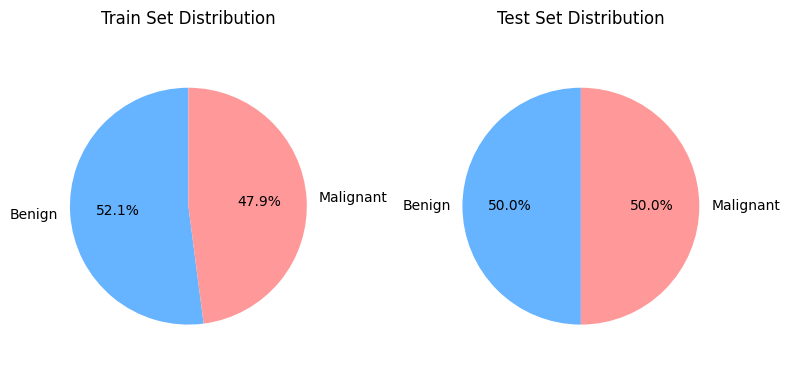

In [5]:
import os
import matplotlib.pyplot as plt

# Define the paths to the train and test directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
test_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\test'

# Function to count images in each class
def count_images(directory):
    benign_path = os.path.join(directory, 'benign')
    malignant_path = os.path.join(directory, 'malignant')

    benign_count = len(os.listdir(benign_path)) if os.path.exists(benign_path) else 0
    malignant_count = len(os.listdir(malignant_path)) if os.path.exists(malignant_path) else 0

    return benign_count, malignant_count

# Count images in train and test sets
train_benign_count, train_malignant_count = count_images(train_dir)
test_benign_count, test_malignant_count = count_images(test_dir)

# Function to plot pie chart for class distribution
def plot_pie_chart(train_counts, test_counts):
    classes = ['Benign', 'Malignant']

    # Plot for training set
    plt.figure(figsize=(8, 4))  # Reduced figure size

    plt.subplot(1, 2, 1)
    plt.pie(train_counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('Train Set Distribution')
    plt.axis('equal')  # Ensures pie chart is circular

    # Plot for testing set
    plt.subplot(1, 2, 2)
    plt.pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('Test Set Distribution')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

# Plot pie charts for both sets
plot_pie_chart(
    [train_benign_count, train_malignant_count],
    [test_benign_count, test_malignant_count]
)

## Pixel Intensity Distribution

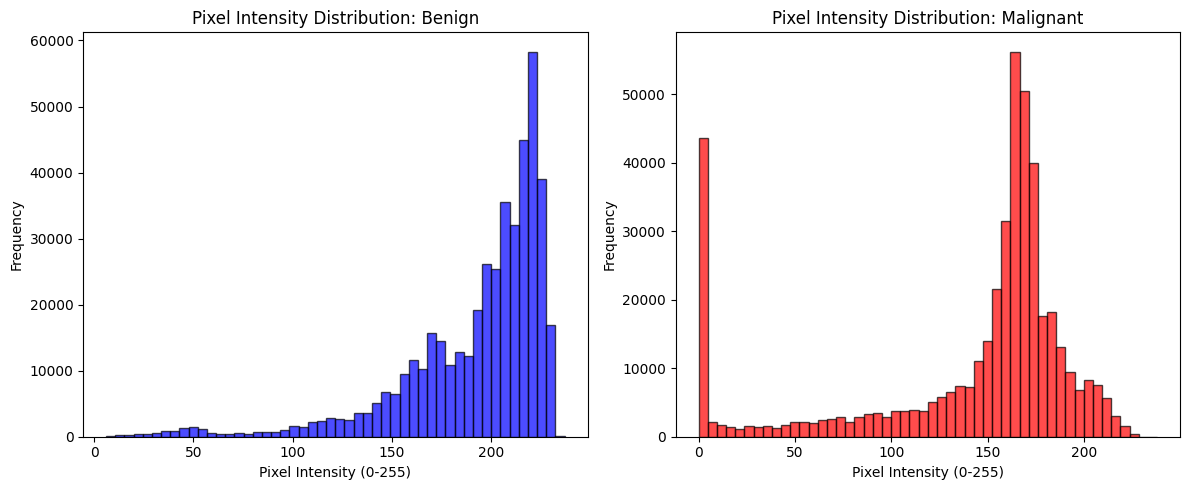

In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to plot pixel intensity distribution side by side
def plot_pixel_intensity_distribution_side_by_side(benign_images, malignant_images):
    # Collect pixel values from benign images
    benign_pixel_values = []
    for image_path in benign_images:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        benign_pixel_values.extend(np.array(img).flatten())  # Flatten into a 1D array

    # Collect pixel values from malignant images
    malignant_pixel_values = []
    for image_path in malignant_images:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        malignant_pixel_values.extend(np.array(img).flatten())

    # Plot side-by-side histograms
    plt.figure(figsize=(12, 5))  # Adjusted figure size for side-by-side view

    # Benign images histogram
    plt.subplot(1, 2, 1)
    plt.hist(benign_pixel_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Pixel Intensity Distribution: Benign')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')

    # Malignant images histogram
    plt.subplot(1, 2, 2)
    plt.hist(malignant_pixel_values, bins=50, color='red', edgecolor='black', alpha=0.7)
    plt.title('Pixel Intensity Distribution: Malignant')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Get 5 images from each category (benign and malignant)
num_images = 5  # Number of images to analyze from each category
benign_images = [os.path.join(benign_path, img) for img in os.listdir(benign_path)[:num_images]]
malignant_images = [os.path.join(malignant_path, img) for img in os.listdir(malignant_path)[:num_images]]

# Plot pixel intensity distributions side by side
plot_pixel_intensity_distribution_side_by_side(benign_images, malignant_images)


##### The code collects pixel intensity values from a set of benign and malignant images, converts them to grayscale, and then plots their distributions as histograms to visualize differences in intensity. It analyzes the first five images from each category in the specified dataset directories.

##### The code sets up data augmentation for melanoma images using TensorFlow's `ImageDataGenerator` to generate variations (like rotations and flips) of the original images. It defines a function to display the original image alongside its augmented versions side by side for visual comparison.

## Scatter Plot of Image Dimensions 

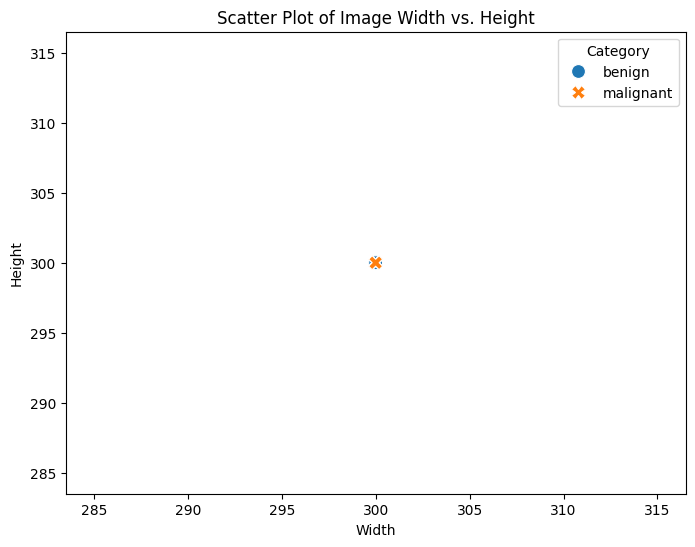

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Function to collect width and height for sample images
def collect_image_sizes(image_dir, category, num_samples=5):
    data = {'category': [], 'filename': [], 'width': [], 'height': []}
    for img_name in os.listdir(image_dir)[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            data['category'].append(category)
            data['filename'].append(img_name)
            data['width'].append(img.width)
            data['height'].append(img.height)
    return data

# Collect sizes for benign and malignant images
benign_sizes = collect_image_sizes(benign_path, 'benign', num_samples=5)
malignant_sizes = collect_image_sizes(malignant_path, 'malignant', num_samples=5)

# Combine data into a DataFrame
df_benign = pd.DataFrame(benign_sizes)
df_malignant = pd.DataFrame(malignant_sizes)
df = pd.concat([df_benign, df_malignant], ignore_index=True)

# Scatter Plot of Width vs. Height for Each Category
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='width', y='height', hue='category', style='category', s=100)
plt.title('Scatter Plot of Image Width vs. Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Category')
plt.show()

##### The code collects the dimensions of a sample of benign and malignant melanoma images, creating a DataFrame to store their width and height. It then generates a scatter plot to visualize the relationship between image width and height for each category, distinguishing them by color and style.

## Heatmap

Heatmap for benign images:

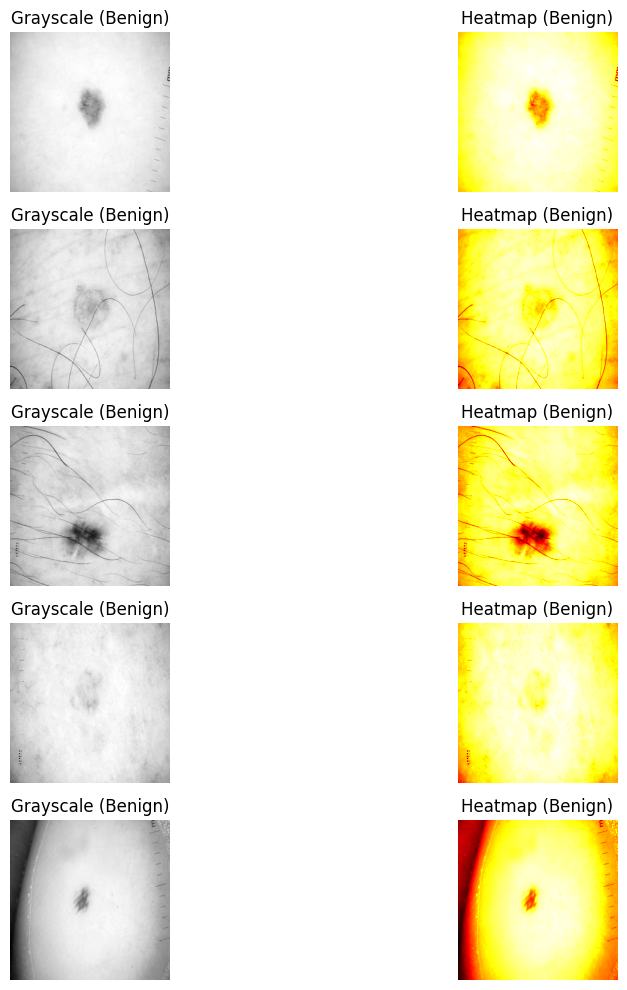

Heatmap for malignant images:

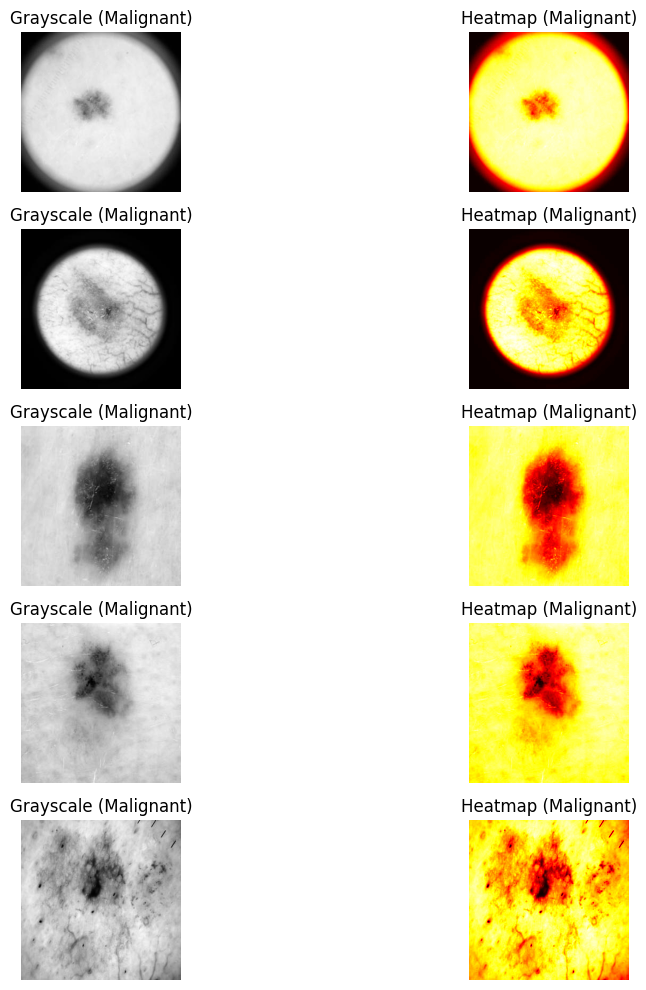

In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Function to convert images to grayscale and display them with heatmaps horizontally
def show_heatmap_horizontal(image_dir, category, num_samples=5):
    plt.figure(figsize=(12, 2 * num_samples))  # Set figure size to fit horizontally

    for i, img_name in enumerate(os.listdir(image_dir)[:num_samples]):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            gray_img = img.convert('L')  # Convert to grayscale
            gray_array = np.array(gray_img)  # Convert to numpy array for plotting

            # Original grayscale image on the left
            plt.subplot(num_samples, 2, 2 * i + 1)
            plt.imshow(gray_img, cmap='gray')
            plt.title(f'Grayscale ({category.capitalize()})')
            plt.axis('off')

            # Heatmap on the right
            plt.subplot(num_samples, 2, 2 * i + 2)
            plt.imshow(gray_array, cmap='hot')  # 'hot' colormap for heatmap
            plt.title(f'Heatmap ({category.capitalize()})')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display heatmaps for benign and malignant images
print("Heatmap for benign images:")
show_heatmap_horizontal(benign_path, 'benign', num_samples=5)

print("Heatmap for malignant images:")
show_heatmap_horizontal(malignant_path, 'malignant', num_samples=5)

## Grayscale Conversion of Images

Grayscale conversion for benign images:

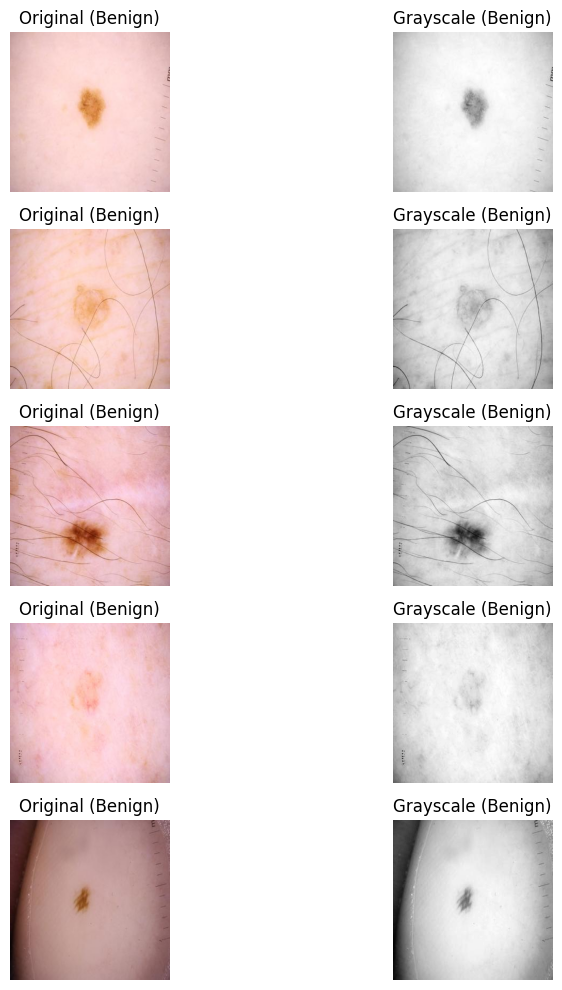

Grayscale conversion for malignant images:

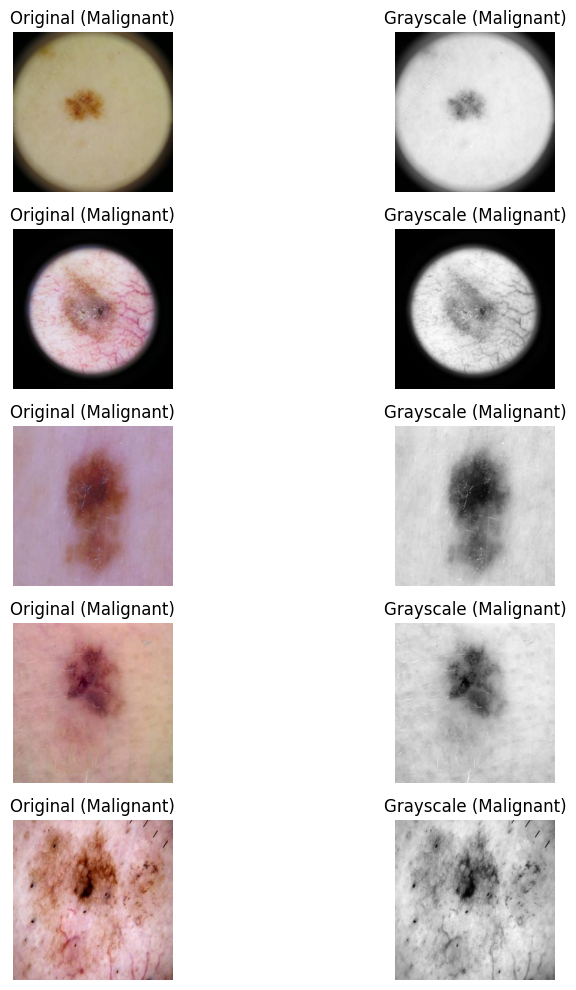

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Function to convert images to grayscale and display them side by side in smaller size
def convert_to_grayscale(image_dir, category, num_samples=5):
    plt.figure(figsize=(10, 2 * num_samples))  # Adjust overall figure size to fit all images

    for i, img_name in enumerate(os.listdir(image_dir)[:num_samples]):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            gray_img = img.convert('L')  # Convert to grayscale
            
            # Original image subplot
            plt.subplot(num_samples, 2, 2 * i + 1)
            plt.imshow(img)
            plt.title(f'Original ({category.capitalize()})')
            plt.axis('off')

            # Grayscale image subplot
            plt.subplot(num_samples, 2, 2 * i + 2)
            plt.imshow(gray_img, cmap='gray')
            plt.title(f'Grayscale ({category.capitalize()})')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Convert and display grayscale images for benign and malignant categories
print("Grayscale conversion for benign images:")
convert_to_grayscale(benign_path, 'benign', num_samples=5)

print("Grayscale conversion for malignant images:")
convert_to_grayscale(malignant_path, 'malignant', num_samples=5)



##### This code defines a function to convert images from the benign and malignant directories into grayscale and display both the original and grayscale images side by side. It uses the Python Imaging Library (PIL) to perform the conversion and Matplotlib for visualization.

## Data Normalization

Found 3200 images belonging to 1 classes.Found 2947 images belonging to 1 classes.Comparing benign images:

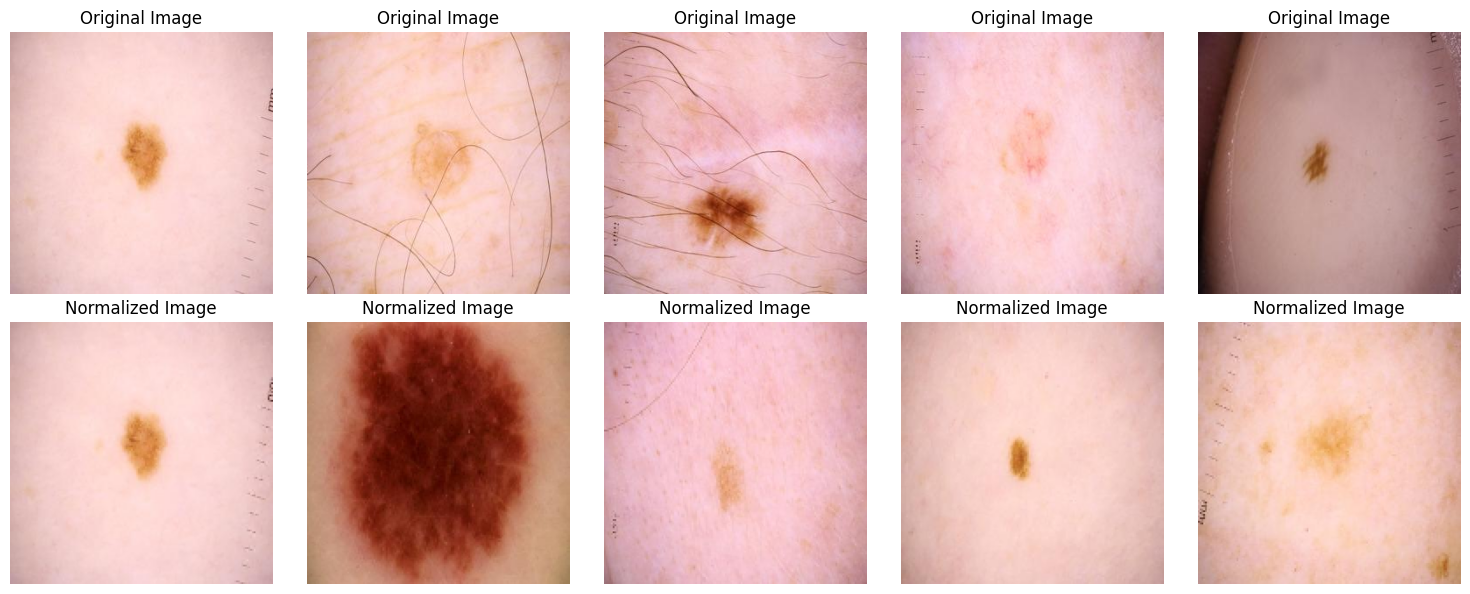

Comparing malignant images:

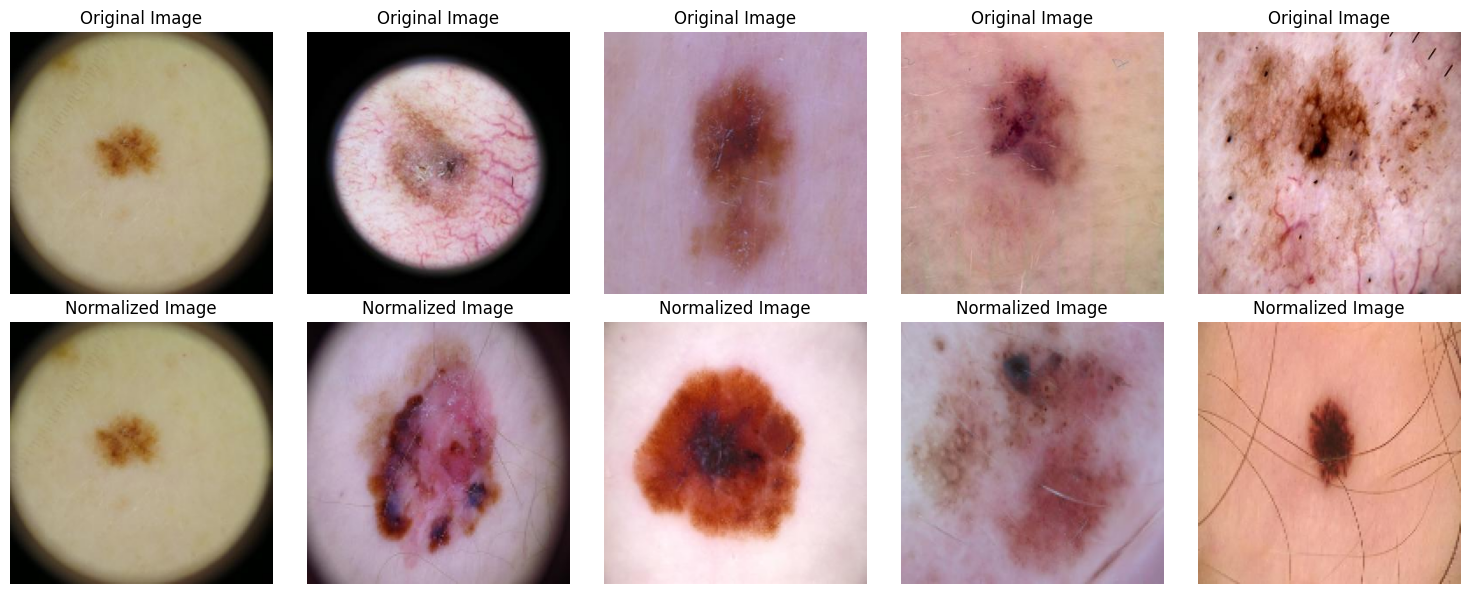

In [20]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

# Define paths to the benign and malignant directories
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Set up the ImageDataGenerator for data normalization
datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Normalize pixel values to [0, 1]
)

# Load original images for comparison
def load_original_images(image_dir, num_samples=5):
    original_images = []
    for img_name in os.listdir(image_dir)[:num_samples]:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        original_images.append(img)
    return original_images

# Function to display original and normalized images side by side
def display_comparison_images(original_images, generator, num_images=5):
    plt.figure(figsize=(15, 6))
    
    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Original Image')
        
        # Display normalized image
        img, _ = next(generator)
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(img[0])  # Show the first image in the batch
        plt.axis('off')
        plt.title('Normalized Image')

    plt.tight_layout()
    plt.show()

# Load original benign and malignant images
benign_original_images = load_original_images(benign_path)
malignant_original_images = load_original_images(malignant_path)

# Load and normalize images
benign_gen = datagen.flow_from_directory(
    train_dir,
    classes=['benign'],
    target_size=(150, 150),  # Resize images if needed
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

malignant_gen = datagen.flow_from_directory(
    train_dir,
    classes=['malignant'],
    target_size=(150, 150),  # Resize images if needed
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Display comparison for benign images
print("Comparing benign images:")
display_comparison_images(benign_original_images, benign_gen)

# Display comparison for malignant images
print("Comparing malignant images:")
display_comparison_images(malignant_original_images, malignant_gen)

##### This code sets up image normalization for a melanoma dataset using TensorFlow's `ImageDataGenerator`. It specifies paths for benign and malignant image directories and initializes the `ImageDataGenerator` to rescale pixel values to the range [0, 1]. The code then creates generators for loading and normalizing images from the specified directories while resizing them to 150x150 pixels. Finally, a function is defined to visualize a few normalized images from each class, which are displayed in a grid format. This helps ensure that the images are correctly prepared for further processing or training in a machine learning model.

#  Data Augmentation

Processing benign images:

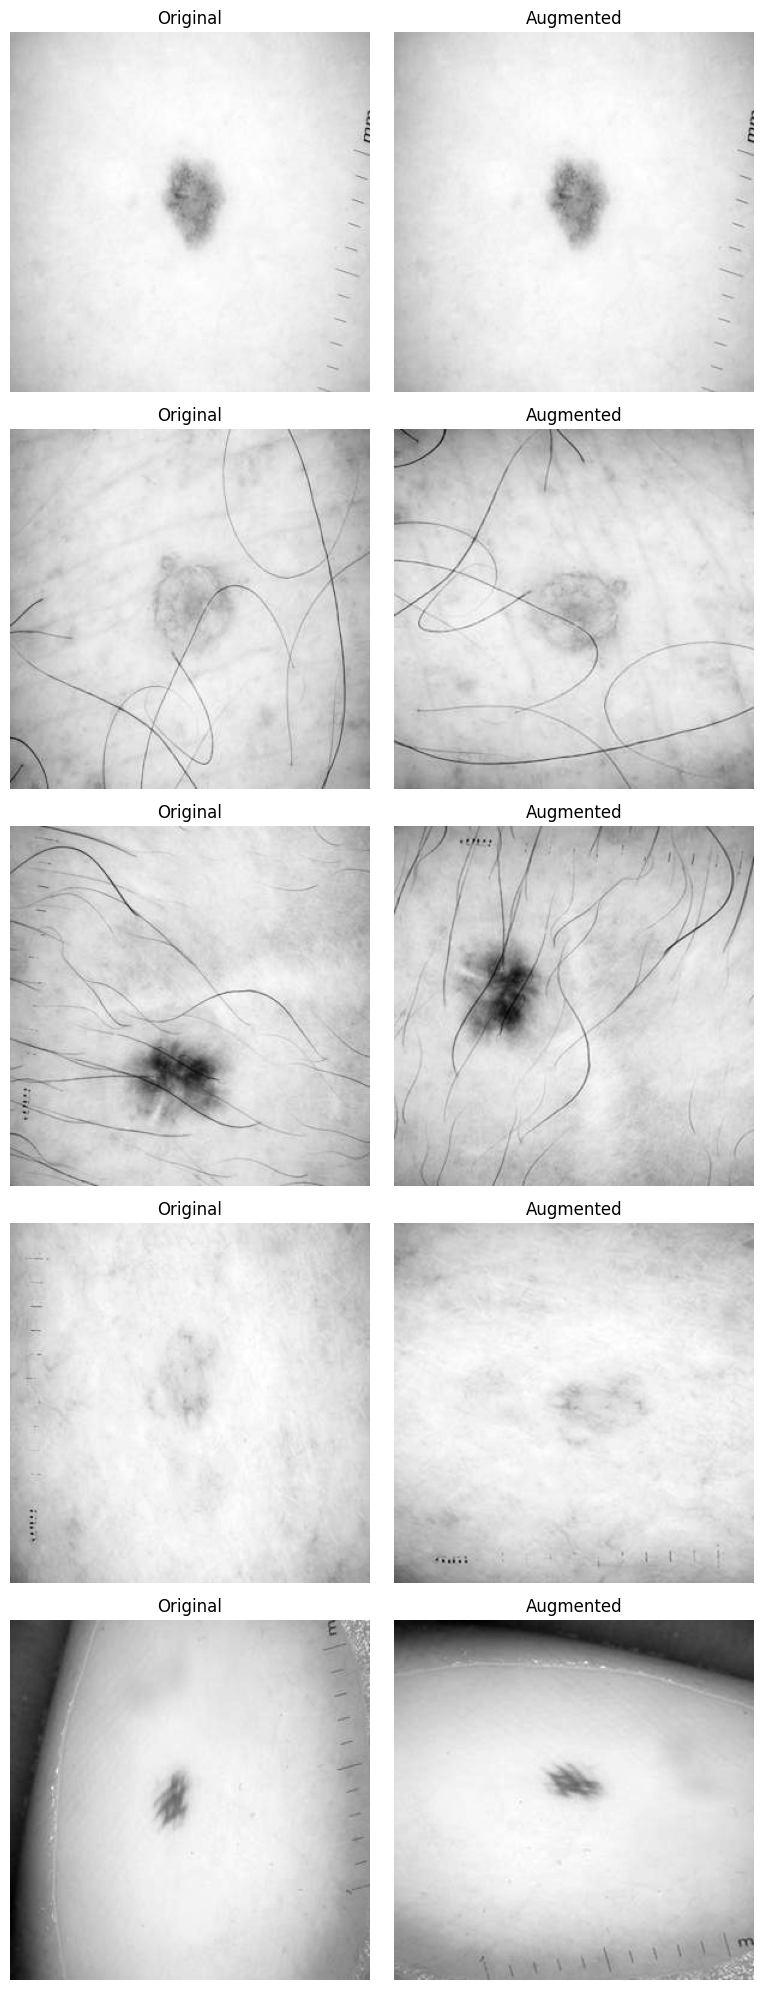

Processing malignant images:

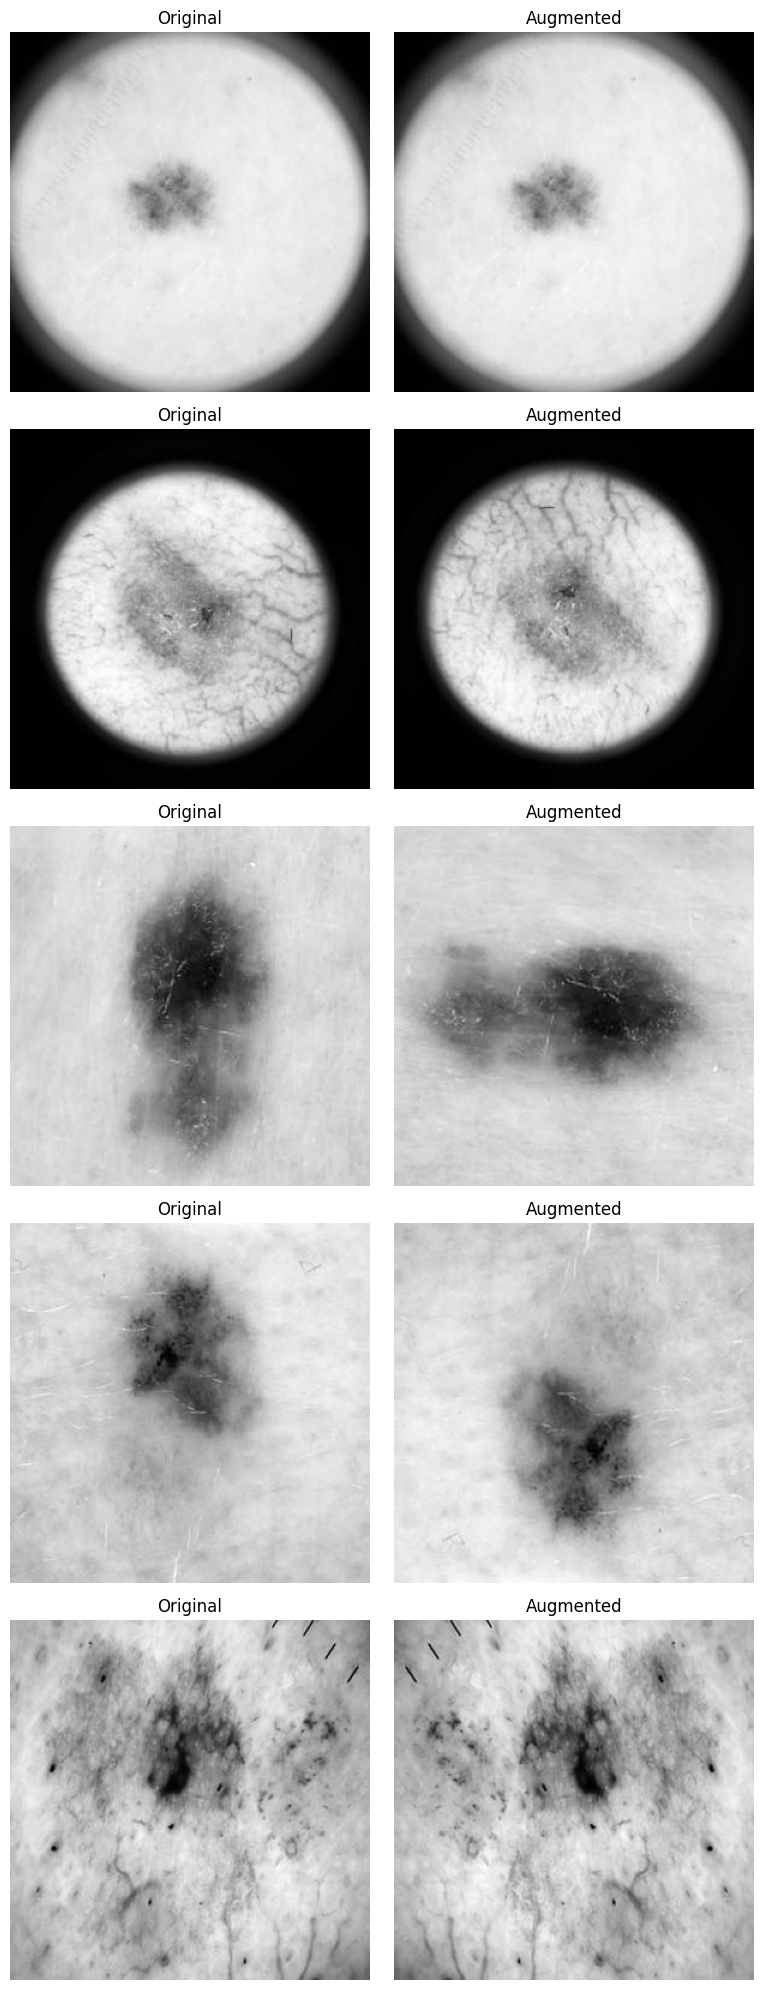

Augmented images have been saved successfully.

In [3]:
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

# Define paths for training images
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Define paths for saving augmented images
augmented_benign_path = os.path.join(train_dir, 'augmented_benign')
augmented_malignant_path = os.path.join(train_dir, 'augmented_malignant')
os.makedirs(augmented_benign_path, exist_ok=True)
os.makedirs(augmented_malignant_path, exist_ok=True)

def load_and_preprocess_image(file_path, normalize=True):
    # Load image, convert to grayscale, and normalize
    img = Image.open(file_path).convert("L")  # Convert to grayscale
    img_array = np.array(img, dtype=np.float32)
    if normalize:
        img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def augment_image(image_array):
    # Convert normalized array back to PIL image for transformations
    img = Image.fromarray((image_array * 255).astype(np.uint8))

    # Apply random transformations
    if random.random() > 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        img = img.rotate(random.choice([90, 180, 270]))

    # Apply random scaling
    scale_factor = random.uniform(0.8, 1.2)
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    # Resize back to original size for consistency
    img = img.resize((image_array.shape[1], image_array.shape[0]), Image.Resampling.LANCZOS)

    # Convert back to normalized array
    augmented_array = np.array(img, dtype=np.float32) / 255.0
    return augmented_array

def process_and_save_images(input_dir, output_dir, sample_count=5):
    original_images = []
    augmented_images = []
    
    for i, filename in enumerate(os.listdir(input_dir)):
        file_path = os.path.join(input_dir, filename)
        if os.path.isfile(file_path):
            # Load, preprocess, and augment
            image = load_and_preprocess_image(file_path)
            augmented_image = augment_image(image)
            
            # Save augmented image
            output_path = os.path.join(output_dir, f"aug_{filename}")
            Image.fromarray((augmented_image * 255).astype(np.uint8)).save(output_path)
            
            # Collect a few samples for visualization
            if i < sample_count:
                original_images.append(image)
                augmented_images.append(augmented_image)

    # Display sampled original and augmented images
    fig, axes = plt.subplots(sample_count, 2, figsize=(8, 4 * sample_count))
    for idx, (original, augmented) in enumerate(zip(original_images, augmented_images)):
        axes[idx, 0].imshow(original, cmap='gray')
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title("Original")
        
        axes[idx, 1].imshow(augmented, cmap='gray')
        axes[idx, 1].axis('off')
        axes[idx, 1].set_title("Augmented")

    plt.tight_layout()
    plt.show()

# Process and save augmented images for benign and malignant categories
print("Processing benign images:")
process_and_save_images(benign_path, augmented_benign_path)
print("Processing malignant images:")
process_and_save_images(malignant_path, augmented_malignant_path)

print("Augmented images have been saved successfully.")

##### The code sets up data augmentation for melanoma images using TensorFlow's `ImageDataGenerator` to generate variations (like rotations and flips) of the original images. It defines a function to display the original image alongside its augmented versions side by side for visual comparison.

In [24]:
import keras
print(keras.__version__)

3.6.0

In [14]:
pip install imagehash

[notice] A new release of pip is available: 24.2 -> 24.3.1[notice] To update, run: python.exe -m pip install --upgrade pip

##  Duplicate images

In [18]:
import imagehash
import os
from PIL import Image

def find_duplicates(image_dir):
    """Finds and returns duplicate images within a directory."""
    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    return duplicates

# --- Run duplicate detection ---
train_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'  # Update this path
test_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\test'    # Update this path

datasets = [
    (os.path.join(train_path, 'benign'), "train_benign"),
    (os.path.join(train_path, 'malignant'), "train_malignant"),
    (os.path.join(test_path, 'benign'), "test_benign"),
    (os.path.join(test_path, 'malignant'), "test_malignant")
]

for dataset_path, dataset_name in datasets:
    duplicates = find_duplicates(dataset_path)
    duplicate_count = len(duplicates)
    print(f"Number of duplicate images in {dataset_name}: {duplicate_count}")

    # Print duplicates if any
    if duplicates:
        print(f"Duplicates found in {dataset_name}:")
        for original, duplicate in duplicates:
            print(f"Original: {original}")
            print(f"Duplicate: {duplicate}")
    else:
        print(f"No duplicates found in {dataset_name}.")

Number of duplicate images in train_benign: 3Duplicates found in train_benign:Original: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_2241.jpgDuplicate: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_2703.jpgOriginal: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_1998.jpgDuplicate: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_3040.jpgOriginal: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_4984.jpgDuplicate: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign\melanoma_655.jpgNumber of duplicate images in train_malignant: 10Duplicates found in train_malignant:Original: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\malignant\melanoma_5698.jpgDuplicate: C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\maligna

In [2]:
import os
import numpy as np
from PIL import Image
import random

# Define paths for training images
train_dir = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
benign_path = os.path.join(train_dir, 'benign')
malignant_path = os.path.join(train_dir, 'malignant')

# Define paths for saving augmented images
augmented_benign_path = os.path.join(train_dir, 'augmented_benign')
augmented_malignant_path = os.path.join(train_dir, 'augmented_malignant')
os.makedirs(augmented_benign_path, exist_ok=True)
os.makedirs(augmented_malignant_path, exist_ok=True)

def load_and_preprocess_image(file_path, normalize=True):
    # Load image, convert to grayscale, and normalize
    img = Image.open(file_path).convert("L")  # Convert to grayscale
    img_array = np.array(img, dtype=np.float32)
    if normalize:
        img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def augment_image(image_array):
    # Convert normalized array back to PIL image for transformations
    img = Image.fromarray((image_array * 255).astype(np.uint8))

    # Apply random transformations
    if random.random() > 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    if random.random() > 0.5:
        img = img.rotate(random.choice([90, 180, 270]))

    # Apply random scaling
    scale_factor = random.uniform(0.8, 1.2)
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    # Resize back to original size for consistency
    img = img.resize((image_array.shape[1], image_array.shape[0]), Image.Resampling.LANCZOS)

    # Convert back to normalized array
    augmented_array = np.array(img, dtype=np.float32) / 255.0
    return augmented_array

def process_and_save_images(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if os.path.isfile(file_path):
            # Load, preprocess, and augment
            image = load_and_preprocess_image(file_path)
            augmented_image = augment_image(image)
            
            # Save augmented image
            output_path = os.path.join(output_dir, f"aug_{filename}")
            Image.fromarray((augmented_image * 255).astype(np.uint8)).save(output_path)

# Process and save augmented images for benign and malignant categories
process_and_save_images(benign_path, augmented_benign_path)
process_and_save_images(malignant_path, augmented_malignant_path)

print("Augmented images have been saved successfully.")

Augmented images have been saved successfully.

In [7]:
import imagehash
import os
from PIL import Image

def find_duplicates(image_dir):
    """Finds and returns duplicate images within a directory using perceptual hashing in RGB mode."""
    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    # Use perceptual hash (phash) without converting to grayscale
                    hash = imagehash.phash(img)  
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    return duplicates

# Define paths for the train and test directories
train_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train'
test_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\test'

# List of dataset paths and their labels
datasets = [
    (os.path.join(train_path, 'benign'), "train_benign"),
    (os.path.join(train_path, 'malignant'), "train_malignant"),
    (os.path.join(test_path, 'benign'), "test_benign"),
    (os.path.join(test_path, 'malignant'), "test_malignant")
]

# Run duplicate detection and print results
for dataset_path, dataset_name in datasets:
    duplicates = find_duplicates(dataset_path)
    duplicate_count = len(duplicates)
    print(f"Number of duplicate images in {dataset_name}: {duplicate_count}")

    # Uncomment to print duplicates' paths
    # if duplicates:
    #     print(f"Duplicates found in {dataset_name}:")
    #     for original, duplicate in duplicates:
    #         print(f"Original: {original} -> Duplicate: {duplicate}")

Number of duplicate images in train_benign: 3Number of duplicate images in train_malignant: 10Number of duplicate images in test_benign: 1Number of duplicate images in test_malignant: 0

In [8]:
import imagehash
from PIL import Image
import os
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_phash_rgb(image_path):
    """Calculates perceptual hash for an RGB image."""
    with Image.open(image_path) as img:
        return imagehash.phash(img)  # Use the RGB image directly

# Dummy ground truth labels and predictions (replace with real values)
# Suppose you manually labeled duplicates in 'true_labels'
# '1' indicates duplicates; '0' indicates unique pairs
true_labels = [1, 0, 1, 0, 1]  # Replace with actual ground truth values
predicted_labels = [1, 0, 1, 1, 0]  # Replace with actual predictions from your model

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.6666666666666666Recall: 0.6666666666666666F1-Score: 0.6666666666666666

In [9]:
import imagehash
import os
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_phash_rgb(image_path):
    """Calculate perceptual hash for an RGB image."""
    with Image.open(image_path) as img:
        return imagehash.phash(img)  # Use the RGB image directly

def find_duplicates(image_dir):
    """Detect duplicates based on perceptual hashing in RGB."""
    image_hashes = {}  # Store image hashes
    duplicates = []    # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                img_hash = calculate_phash_rgb(img_path)  # Compute perceptual hash
                if img_hash in image_hashes:
                    duplicates.append((image_hashes[img_hash], img_path))  # Store duplicate
                else:
                    image_hashes[img_hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    return duplicates

# Manually labeled ground truth (1 = duplicate, 0 = unique)
# Example of manually labeling some pairs of images as duplicates (replace with real ground truth)
true_labels = [1, 0, 1, 0, 1, 0]  # Example true labels
predicted_labels = [1, 0, 1, 0, 1, 1]  # Predicted duplicate labels

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Example dataset paths (replace with actual paths to your dataset)
dataset_path = r'C:\Users\Lenovo\Downloads\melanoma_images\melanoma_cancer_dataset\train\benign'
duplicates = find_duplicates(dataset_path)
print(f"Number of duplicate images detected: {len(duplicates)}")

Precision: 0.75Recall: 1.00F1-Score: 0.86Number of duplicate images detected: 3

## Original rgb

Found 7684 images belonging to 2 classes.Found 1921 images belonging to 2 classes.Found 1000 images belonging to 2 classes.

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓┃ Layer (type)                 ┃ Output Shape          ┃     Param # ┃┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩│ conv2d_3 (Conv2D)            │ (None, 128, 128, 32)  │         896 │├──────────────────────────────┼───────────────────────┼─────────────┤│ max_pooling2d_3              │ (None, 64, 64, 32)    │           0 ││ (MaxPooling2D)               │                       │             │├──────────────────────────────┼───────────────────────┼─────────────┤│ conv2d_4 (Conv2D)            │ (None, 64, 64, 64)    │      18,496 │├──────────────────────────────┼───────────────────────┼─────────────┤│ max_pooling2d_4              │ (None, 32, 32, 64)    │           0 ││ (MaxPooling2D)               │                       │             │├──────────────────────────────┼───────────────────────┼─────────────┤│ conv2d_5 (Conv2D)            │ (None, 32, 32, 128)   │      73,856 │├──────────────────────────────┼───────────────────────┼─────────────┤│ max_pooling2d_5              │ (None, 16, 16, 128)   │           0 ││ (MaxPooling2D)               │                       │             │├──────────────────────────────┼───────────────────────┼─────────────┤│ flatten_1 (Flatten)          │ (None, 32768)         │           0 │├──────────────────────────────┼───────────────────────┼─────────────┤│ dense_2 (Dense)              │ (None, 128)           │   4,194,432 │├──────────────────────────────┼───────────────────────┼─────────────┤│ dropout_1 (Dropout)          │ (None, 128)           │           0 │├──────────────────────────────┼───────────────────────┼─────────────┤│ dense_3 (Dense)              │ (None, 1)             │         129 │└──────────────────────────────┴───────────────────────┴─────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.  self._warn_if_super_not_called()

Epoch 1/10241/241 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - AUC: 0.7612 - Precision: 0.7484 - Recall: 0.5445 - accuracy: 0.6907 - loss: 0.5620 - val_AUC: 0.9415 - val_Precision: 0.8682 - val_Recall: 0.8436 - val_accuracy: 0.8636 - val_loss: 0.3236Epoch 2/10241/241 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - AUC: 0.9198 - Precision: 0.8591 - Recall: 0.7993 - accuracy: 0.8409 - loss: 0.3571 - val_AUC: 0.9501 - val_Precision: 0.8761 - val_Recall: 0.8751 - val_accuracy: 0.8808 - val_loss: 0.2988Epoch 3/10241/241 ━━━━━━━━━━━━━━━━━━━━ 189s 785ms/step - AUC: 0.9393 - Precision: 0.8844 - Recall: 0.8431 - accuracy: 0.8709 - loss: 0.3112 - val_AUC: 0.9593 - val_Precision: 0.9085 - val_Recall: 0.8730 - val_accuracy: 0.8969 - val_loss: 0.2628Epoch 4/10241/241 ━━━━━━━━━━━━━━━━━━━━ 185s 769ms/step - AUC: 0.9404 - Precision: 0.8888 - Recall: 0.8460 - accuracy: 0.8746 - loss: 0.3070 - val_AUC: 0.9632 - val_Precision: 0.9566 - val_Recall: 0.7894 - val_accuracy: 0.8818 - val_loss: 0.2856Epoch 5/10241/241 ━━━━━━━━━━━━

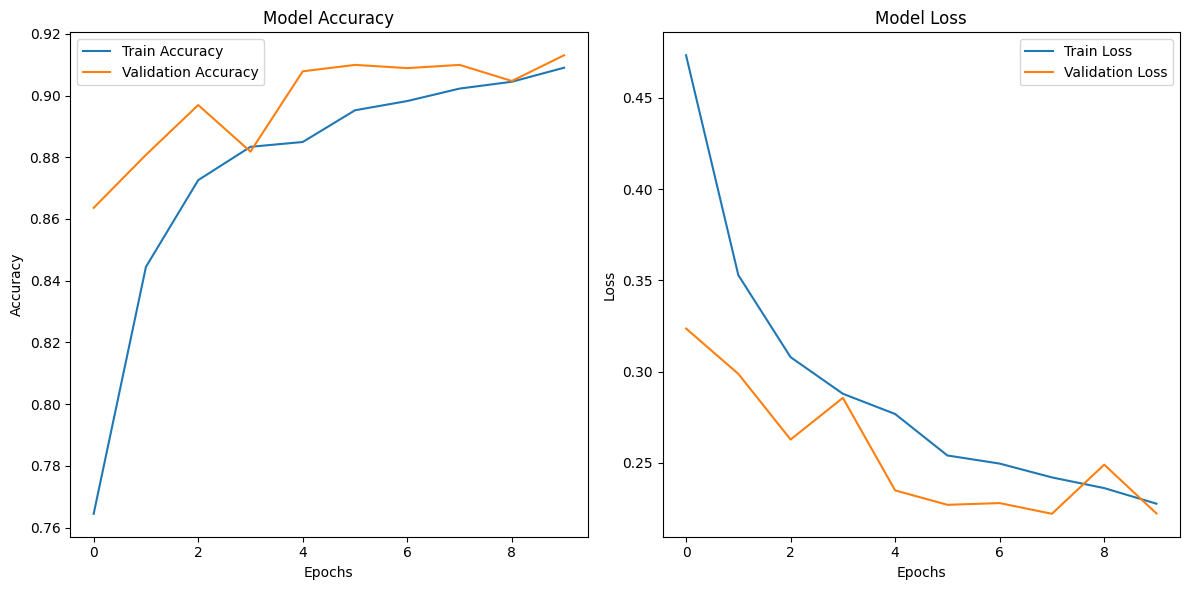

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step              precision  recall  f1-score   supportbenign         0.897590   0.894  0.895792   500.000malignant      0.894422   0.898  0.896208   500.000accuracy       0.896000   0.896  0.896000     0.896macro avg      0.896006   0.896  0.896000  1000.000weighted avg   0.896006   0.896  0.896000  1000.000

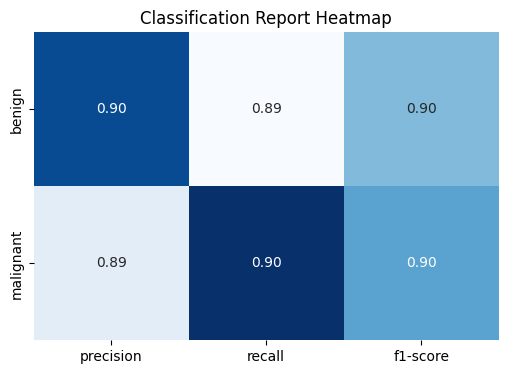

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step

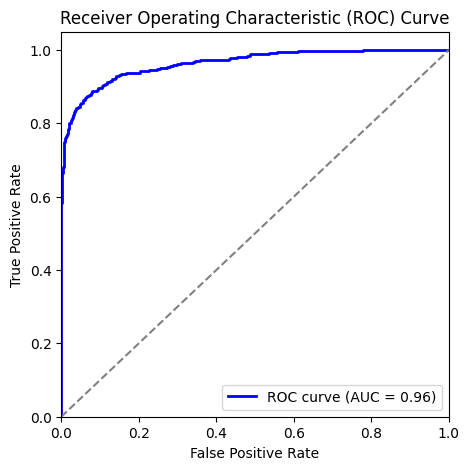

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step

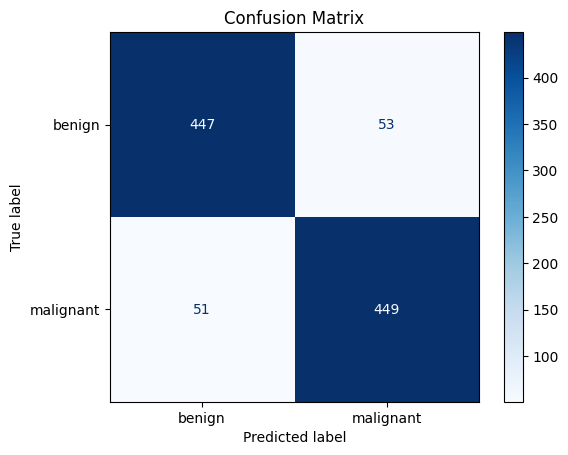

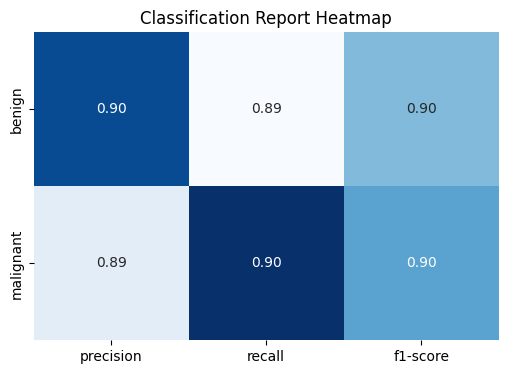

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define paths for training, validation, and test data
train_dir = r"C:\Users\Lenovo\Downloads\archive (1)\melanoma_cancer_dataset\train"
test_dir = r"C:\Users\Lenovo\Downloads\archive (1)\melanoma_cancer_dataset\test"

# Parameters
img_height, img_width = 128, 128  # Resize images to a fixed size
batch_size = 32  # Number of images per batch

# Define ImageDataGenerator with validation split
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # Reserve 20% for validation
)

# Load training data (80% of data used for training)
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Training data
)

# Load validation data (20% of data used for validation)
val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Validation data
)

# Load test data (never used for training)
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Don't shuffle, as you want to evaluate the final results
)

# Build the CNN model
model = models.Sequential([
    # Convolutional layers + MaxPooling layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification (benign vs malignant)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Model summary
model.summary()

# Early stopping callback to stop training if the validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs of no improvement in validation loss
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stopping]
)

# Evaluate the model on test data
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_data)

# Output the test metrics
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Create a figure with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy on the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss on the right
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Get the true labels and predictions from the test data
y_true = test_data.classes  # True labels
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary labels

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

# Convert the classification report to a pandas DataFrame for better readability
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys(), output_dict=True)).transpose()

# Display the report in tabular format
print(report_df)

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), annot=True, cmap='Blues', fmt=".2f", cbar=False)

plt.title('Classification Report Heatmap')
plt.show()

# Get the true labels and predicted probabilities for the test set
y_true = test_data.classes  # True labels
y_pred_prob = model.predict(test_data)  # Predicted probabilities

# For binary classification, y_pred_prob is a single column representing the probability of the positive class
# Since we have a sigmoid output, we use the probabilities directly
y_pred_prob = y_pred_prob.flatten()  # Flatten the output to 1D array

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Get true labels and predicted labels
y_true = test_data.classes  # True labels
y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()  # Predicted labels (0 or 1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), annot=True, cmap='Blues', fmt=".2f", cbar=False)

plt.title('Classification Report Heatmap')
plt.show()

NameError: name 'model' is not defined

## Unique grayscale

Found 7664 images belonging to 2 classes.Found 1915 images belonging to 2 classes.Found 999 images belonging to 2 classes.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ flatten (Flatten)                    │ (None, 32768)               │               0 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ dropout (Dropout)                    │ (None, 128)                 │               0 │├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤│ dense_1 (Dense)                      │ (None, 1)                   │             129 │└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,233 (16.35 MB)

 Trainable params: 4,287,233 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.  self._warn_if_super_not_called()

Epoch 1/15240/240 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - AUC: 0.7081 - Precision: 0.6875 - Recall: 0.4190 - accuracy: 0.6435 - loss: 0.6039 - val_AUC: 0.9080 - val_Precision: 0.7185 - val_Recall: 0.9378 - val_accuracy: 0.7943 - val_loss: 0.4431Epoch 2/15240/240 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - AUC: 0.8824 - Precision: 0.7844 - Recall: 0.7805 - accuracy: 0.7892 - loss: 0.4278 - val_AUC: 0.9189 - val_Precision: 0.8215 - val_Recall: 0.8233 - val_accuracy: 0.8298 - val_loss: 0.3673Epoch 3/15240/240 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - AUC: 0.9128 - Precision: 0.8124 - Recall: 0.8146 - accuracy: 0.8216 - loss: 0.3726 - val_AUC: 0.9281 - val_Precision: 0.8752 - val_Recall: 0.7568 - val_accuracy: 0.8319 - val_loss: 0.3525Epoch 4/15240/240 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - AUC: 0.9284 - Precision: 0.8451 - Recall: 0.8402 - accuracy: 0.8478 - loss: 0.3399 - val_AUC: 0.9451 - val_Precision: 0.8581 - val_Recall: 0.8637 - val_accuracy: 0.8663 - val_loss: 0.3243Epoch 5/15240/240 ━━━━━━━━━━━━━━━━━━

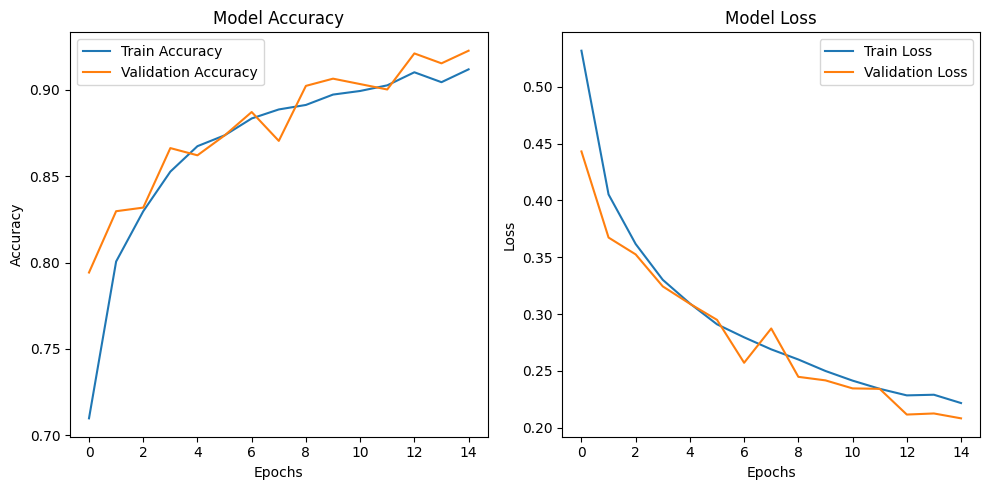

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 650ms/step              precision    recall  f1-score     supportbenign         0.902893  0.875752  0.889115  499.000000malignant      0.879612  0.906000  0.892611  500.000000accuracy       0.890891  0.890891  0.890891    0.890891macro avg      0.891252  0.890876  0.890863  999.000000weighted avg   0.891240  0.890891  0.890865  999.000000

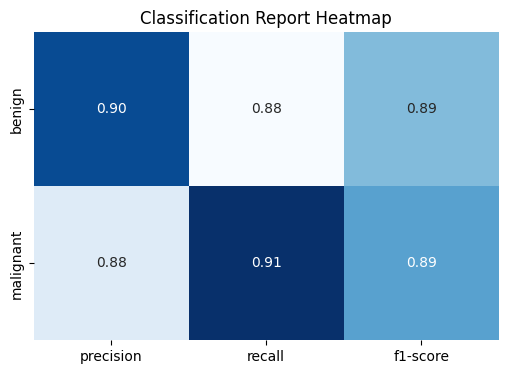

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step

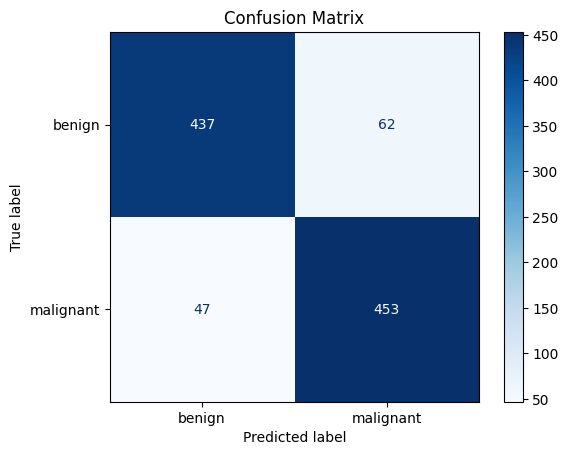

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step

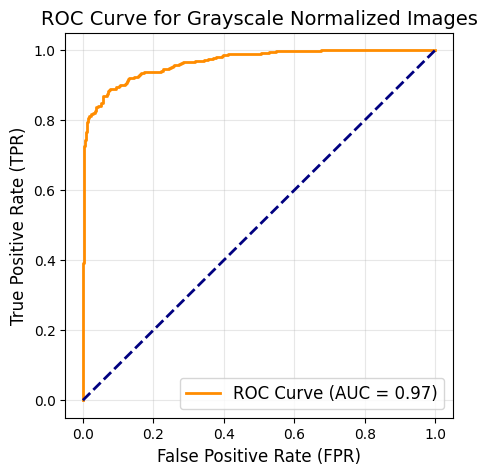

In [5]:
# Define paths for training and validation data
train_dir = r"C:\Users\Lenovo\Downloads\grayscale_unique\grayscale_unique\train"
test_dir = r"C:\Users\Lenovo\Downloads\grayscale_unique\grayscale_unique\test"


# Parameters
img_height, img_width = 128, 128  # Resize images to a fixed size
batch_size = 32  # Number of images per batch



# Define ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # Reserve 20% for validation
)

# Load training data (80% of data used for training)
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    color_mode='grayscale'  # Ensure grayscale loading
)

# Load validation data (20% of data used for validation)
val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    color_mode='grayscale'  # Ensure grayscale loading
)

# Load test data (never used for training)
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'  # Ensure grayscale loading
)




# Build the CNN model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(img_height, img_width, 1)),  # Define the input shape explicitly for grayscale images

    # Convolutional layers + MaxPooling layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten layer
    layers.Flatten(),
    
    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification (benign vs malignant)
])




# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate here
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# Model summary
model.summary()




# Early stopping callback to stop training if the validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs of no improvement in validation loss
    restore_best_weights=True
)




# Train the model
history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[early_stopping]
)




# Evaluate the model on test data
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(val_data)

# Output the test metrics
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")




# Create a figure with two subplots (one for accuracy and one for loss)
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy on the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss on the right
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()




# Get the true labels and predictions from the test data
y_true = test_data.classes  # True labels
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary labels

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

# Convert the classification report to a pandas DataFrame for better readability
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys(), output_dict=True)).transpose()

# Display the report in tabular format
print(report_df)




# Plot the classification report as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), annot=True, cmap='Blues', fmt=".2f", cbar=False)

plt.title('Classification Report Heatmap')
plt.show()




# Get true labels and predicted labels
y_true = test_data.classes  # True labels
y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()  # Predicted labels (0 or 1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()




# Predict probabilities on the test data
y_pred_prob = model.predict(test_data)  # Predicted probabilities

# Extract true labels from the test data
y_true = test_data.classes  # Ground truth labels

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Compute AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)




# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Grayscale Normalized Images', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()




## Gray augumented Images

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths for augmented malignant and benign data
train_dir_augmented = r"C:\Users\Lenovo\Downloads\archive (1)\melanoma_cancer_dataset\gray_aug_images\gray_aug_images"
img_height, img_width = 150, 150  # Resize images to a fixed size
batch_size = 32

# ImageDataGenerator with augmentation for training data
train_datagen_augmented = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% for validation
)

# Generators for training and validation using augmented grayscale images
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir_augmented,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir_augmented,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

# Define and compile the CNN model
model_augmented = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),  # Grayscale input
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_augmented.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_augmented = model_augmented.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.samples // batch_size,
    validation_data=val_generator_augmented,
    validation_steps=val_generator_augmented.samples // batch_size,
    epochs=10
)

# Evaluate the model on validation data
val_loss_augmented, val_accuracy_augmented = model_augmented.evaluate(val_generator_augmented)
print(f"Augmented Model Validation Loss: {val_loss_augmented}")
print(f"Augmented Model Validation Accuracy: {val_accuracy_augmented}")

Found 38316 images belonging to 2 classes.Found 9579 images belonging to 2 classes.

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

Epoch 1/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 1672s 1s/step - accuracy: 0.7190 - loss: 0.5525 - val_accuracy: 0.7676 - val_loss: 0.4499Epoch 2/10   1/1197 ━━━━━━━━━━━━━━━━━━━━ 12:28 625ms/step - accuracy: 0.8125 - loss: 0.3439

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.  self.gen.throw(value)

1197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 225us/step - accuracy: 0.8125 - loss: 0.3439 - val_accuracy: 0.9091 - val_loss: 0.3831Epoch 3/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 984s 822ms/step - accuracy: 0.7950 - loss: 0.4098 - val_accuracy: 0.8181 - val_loss: 0.3753Epoch 4/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 132us/step - accuracy: 0.7188 - loss: 0.4257 - val_accuracy: 0.9091 - val_loss: 0.3526Epoch 5/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 28754s 24s/step - accuracy: 0.8057 - loss: 0.3936 - val_accuracy: 0.8227 - val_loss: 0.3719Epoch 6/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 1s 118us/step - accuracy: 0.8438 - loss: 0.4176 - val_accuracy: 0.7273 - val_loss: 0.4040Epoch 7/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 33396s 28s/step - accuracy: 0.8257 - loss: 0.3700 - val_accuracy: 0.8284 - val_loss: 0.3726Epoch 8/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.8438 - loss: 0.3438 - val_accuracy: 0.5455 - val_loss: 0.8125Epoch 9/101197/1197 ━━━━━━━━━━━━━━━━━━━━ 402s 336ms/step - accuracy: 0.8344 - loss: 0.3627 - va

## RGB Augmented

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths for augmented malignant and benign data
aug_dir = r"C:\Users\Lenovo\Downloads\archive (1)\melanoma_cancer_dataset\augmented_images\augmented_images"
img_height, img_width = 150, 150  # Resize images to a fixed size
batch_size = 64

# ImageDataGenerator with augmentation for training data
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # Reserve 20% for validation
)

# Generators for training and validation using augmented images
augmented_train_generator = augmented_train_datagen.flow_from_directory(
    aug_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

augmented_val_generator = augmented_train_datagen.flow_from_directory(
    aug_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Define and compile the CNN model
augmented_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),  # RGB input
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
augmented_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
augmented_history = augmented_model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // augmented_train_generator.batch_size,
    validation_data=augmented_val_generator,
    validation_steps=augmented_val_generator.samples // augmented_val_generator.batch_size,
    epochs=10
)

# Evaluate the model on validation data
augmented_loss, augmented_accuracy = augmented_model.evaluate(augmented_val_generator)
print(f"Augmented Model Validation Loss: {augmented_loss}")
print(f"Augmented Model Validation Accuracy: {augmented_accuracy}")

Found 38316 images belonging to 2 classes.
Found 9579 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


598/598 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.7696 - loss: 0.4957 - val_accuracy: 0.8865 - val_loss: 0.2723
Epoch 2/10
  1/598 ━━━━━━━━━━━━━━━━━━━━ 12:46 1s/step - accuracy: 0.9062 - loss: 0.2215

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - accuracy: 0.9062 - loss: 0.2215 - val_accuracy: 0.9302 - val_loss: 0.1941
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 847s 1s/step - accuracy: 0.8790 - loss: 0.2870 - val_accuracy: 0.8926 - val_loss: 0.2617
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - accuracy: 0.8125 - loss: 0.4155 - val_accuracy: 0.9070 - val_loss: 0.3087
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 839s 1s/step - accuracy: 0.8946 - loss: 0.2569 - val_accuracy: 0.9072 - val_loss: 0.2419
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8594 - loss: 0.2808 - val_accuracy: 0.8605 - val_loss: 0.2754
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 841s 1s/step - accuracy: 0.9014 - loss: 0.2433 - val_accuracy: 0.9093 - val_loss: 0.2343
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 575us/step - accuracy: 0.9062 - loss: 0.2803 - val_accuracy: 0.9302 - val_loss: 0.1923
Epoch 9/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 840s 1s/step - accuracy: 0.9044 - loss: 0.2338 - val_accuracy: 0

In [4]:
augmented_model.save("RGB_Augmented_Model.h5")
print("Model saved as RGB_Augmented_Model.h5")

Model saved as RGB_Augmented_Model.h5


In [8]:
import pandas as pd

# Model names
model_names = [
    'CNN Original RGB Model',
    'CNN Unique Grayscale Model',
    'CNN Grayscale Augmented Model',
    'CNN Augmented Original RGB Model'
]

# Performance metrics from the provided data
val_accuracy = [0.9131, 0.9227, 0.8606, 0.9102]  # Validation Accuracy
test_accuracy = [0.8960, 0.8960, 0.8654, 0.9187]  # Test Accuracy
test_precision = [0.8944, 0.8968, 0.9029, 0.8972]  # Test Precision
test_recall = [0.8980, 0.9477, 0.9060, 0.9089]  # Test Recall
test_auc = [0.9644, 0.9775, 0.8909, 0.8975]  # Test AUC

# Create a DataFrame
data = {
    'Model': model_names,
    'Validation Accuracy': val_accuracy,
    'Test Accuracy': test_accuracy,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
    'Test AUC': test_auc
}
df = pd.DataFrame(data)

# Display the plain DataFrame
print(df)

                              Model  Validation Accuracy  Test Accuracy  \
0            CNN Original RGB Model               0.9131         0.8960   
1        CNN Unique Grayscale Model               0.9227         0.8960   
2     CNN Grayscale Augmented Model               0.8606         0.8654   
3  CNN Augmented Original RGB Model               0.9102         0.9187   

   Test Precision  Test Recall  Test AUC  
0          0.8944       0.8980    0.9644  
1          0.8968       0.9477    0.9775  
2          0.9029       0.9060    0.8909  
3          0.8972       0.9089    0.8975  


In [9]:
from tabulate import tabulate

# Model names
model_names = [
    'CNN Original RGB Model',
    'CNN Unique Grayscale Model',
    'CNN Grayscale Augmented Model',
    'CNN Augmented Original RGB Model'
]

# Performance metrics from the provided data
test_accuracy = [0.8960, 0.8960, 0.8654, 0.8975]  # Test Accuracy
test_precision = [0.8944, 0.8968, 0.9029, 0.8972]  # Test Precision
test_recall = [0.8980, 0.9477, 0.9060, 0.9089]  # Test Recall

# Calculate F1-scores
test_f1_scores = [
    2 * (precision * recall) / (precision + recall) 
    for precision, recall in zip(test_precision, test_recall)
]

# Data for the table
data = list(zip(model_names, test_accuracy, test_precision, test_f1_scores))

# Headers for the table
headers = ["Model", "Accuracy", "Precision", "F1-Score"]

# Print the table
print(tabulate(data, headers=headers, tablefmt="grid", floatfmt=".4f"))

+----------------------------------+------------+-------------+------------+
| Model                            |   Accuracy |   Precision |   F1-Score |
+==================================+============+=============+============+
| CNN Original RGB Model           |     0.8960 |      0.8944 |     0.8962 |
+----------------------------------+------------+-------------+------------+
| CNN Unique Grayscale Model       |     0.8960 |      0.8968 |     0.9215 |
+----------------------------------+------------+-------------+------------+
| CNN Grayscale Augmented Model    |     0.8654 |      0.9029 |     0.9044 |
+----------------------------------+------------+-------------+------------+
| CNN Augmented Original RGB Model |     0.8975 |      0.8972 |     0.9030 |
+----------------------------------+------------+-------------+------------+


In [11]:
import pandas as pd

# Data for models and their accuracies
data = {
    "S.No": [1, 2, 3, 4],
    "Model": [
        "Unique RGB model",
        "Unique Grayscale model",
        "Grayscale Augmented model",
        "RGB Augmented model"
    ],
    "Accuracy (%)": [89.68, 89.18, 86.25, 89.75]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Rounding the 'Accuracy (%)' column to 2 decimal places
df["Accuracy (%)"] = df["Accuracy (%)"].round(2)

# Adjust display settings for better alignment
pd.set_option("display.colheader_justify", "center")  
pd.set_option("display.width", 1000)  

# Displaying the DataFrame
print("Model Accuracy Comparison")
print(df)

Model Accuracy Comparison
   S.No           Model             Accuracy (%)
0    1            Unique RGB model      89.68   
1    2      Unique Grayscale model      89.18   
2    3   Grayscale Augmented model      86.25   
3    4         RGB Augmented model      89.75   


**CONCLUSION**

I have found that my **RGB augmented model** has the highest **accuracy(89.75)**, so I want to use this model.

**Classification Report**

In [5]:
# Generate true labels and predictions
y_true = augmented_val_generator.classes  # True labels
augmented_val_generator.reset()  # Reset the generator
y_pred_probs = augmented_model.predict(
    augmented_val_generator,
    steps=augmented_val_generator.samples // augmented_val_generator.batch_size + 1
)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() 

# Create a classification report
class_names = list(augmented_val_generator.class_indices.keys())  
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)


150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 419ms/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.52      0.56      0.54      4992
   malignant       0.48      0.44      0.45      4587

    accuracy                           0.50      9579
   macro avg       0.50      0.50      0.50      9579
weighted avg       0.50      0.50      0.50      9579



**Confusion Matrix**

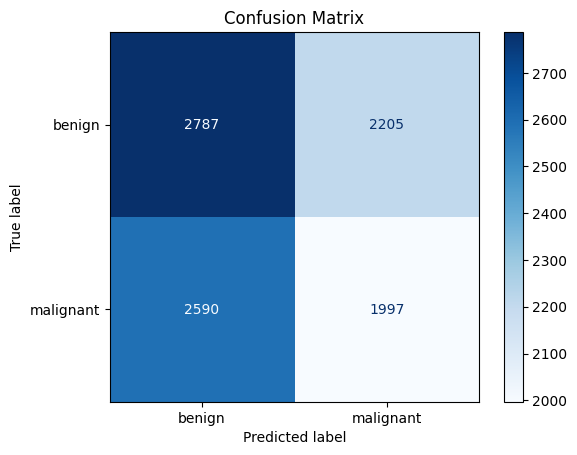

In [7]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(augmented_val_generator.class_indices.keys())  

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()